# 'Luxurious' notebook using BERT for the SMS Spam Collection Dataset
* This is a expensive but high-score notebook using BERT as a base model for the SMS Spam Collection Dataset.
* I only focused on performance, and accuracy 99.61 means that out of 517 samples selected as 10% of the entire dataset, only 2 were incorrect.
* The validation dataset is randomly sampled at each kernel run, and is does not involve in the model's learning.¶
* You can find the full version of the code adopting wandb and hydra on [github](https://github.com/Espresso-AI/bert-sms-spam-classification).

## Abstract
#### 1. Load Dataset & EDA
#### 3. Model & Loss Function
#### 4. Engine
#### 5. Training
#### 6. Test

In [127]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Union, Optional, OrderedDict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# 1. Load Dataset & EDA
## 1) Load and cleaning dataset  

In [128]:
from sklearn.model_selection import train_test_split


def spam_dataframe(
        path: str,
        is_train: bool = True,
        val_ratio: Optional[float] = 0.1,
        random_state: Optional[int] = 42,
        shuffle: bool = True
):
    df = pd.read_csv(path, sep='\t', encoding='iso-8859-1')
    # df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

    df.columns = ['is_spam', 'message']
    df = df[['message', 'is_spam']]
    df['is_spam'] = df['is_spam'] == 'spam'

    if is_train:
        df = df.dropna(axis=0)
        df.drop_duplicates('message', inplace=True, ignore_index=True)

        if val_ratio:
            train_df, val_df = train_test_split(
                df,
                test_size=val_ratio,
                random_state=random_state,
                shuffle=shuffle
            )
            return train_df, val_df
        else:
            return df
    else:
        if val_ratio:
            print('train/val split has been ignored')
        return df


In [129]:
from torch.utils.data import Dataset

class Spam_Dataset(Dataset):

    def __init__(
            self,
            spam_df: pd.DataFrame
    ):
        super().__init__()
        self.df = spam_df
        self.ids = self.df.index.values

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]
        return {
            'message': row['message'],
            'is_spam': row['is_spam']
        }
    

In [130]:
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast


class Spam_Collator:

    def __init__(
            self,
            tokenizer: Union[PreTrainedTokenizer, PreTrainedTokenizerFast],
            max_seq_len: Optional[int] = None,
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len


    def __call__(self, batch):
        texts = [i['message'] for i in batch]
        labels = [i['is_spam'] for i in batch]

        if self.max_seq_len:
            encodings = self.tokenizer(
                texts,
                add_special_tokens=True,
                max_length=self.max_seq_len,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            )
        else:
            encodings = self.tokenizer(
                texts,
                add_special_tokens=True,
                return_tensors="pt",
            )
        encodings = encodings.to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)

        return encodings, labels
    

In [131]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

PATH = './dataset/SMSSpamCollection'
CHECKPOINTS = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(CHECKPOINTS)

df = spam_dataframe(PATH, is_train=False)
dataset = Spam_Dataset(df)
collator = Spam_Collator(tokenizer, None)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collator)

train/val split has been ignored


## 2) EDA

In [132]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  5571 non-null   object
 1   is_spam  5571 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 49.1+ KB


,message,is_spam
count,5571,5571
unique,5168,2
top,"Sorry, I'll call later",False
freq,30,4824


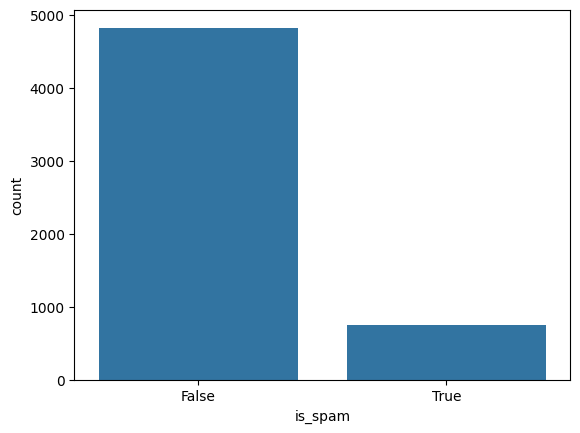

In [133]:
sns.countplot(data=df, x='is_spam')
plt.show()

C:\Users\kevyn\AppData\Local\Temp\ipykernel_17168\1447163172.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  labels = torch.tensor(labels, dtype=torch.long).to(device)


count    5571.000000
mean       25.502962
std        17.806827
min         3.000000
25%        12.000000
50%        20.000000
75%        36.000000
max       238.000000
dtype: float64


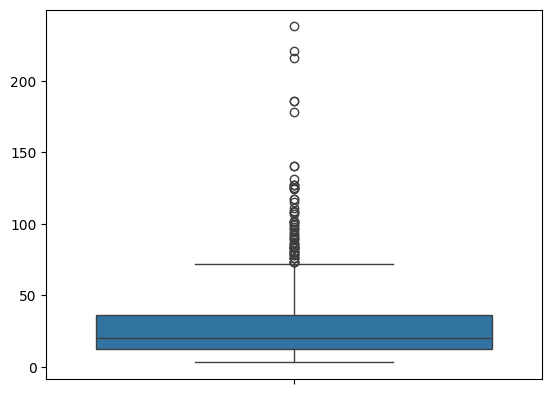

In [134]:
seq_len = []
for i in dataloader:
    seq_len.append(i[0]['input_ids'].shape[-1])

seq_len = pd.Series(seq_len)
print(seq_len.describe())

sns.boxplot(seq_len)
plt.show()

As a result of the EDA, I could find that 32 is quite enough for the max_seq_len of BERT.  
However, in order to minimize information loss, I decided to use 64 which is close to the maximum of the boxplot.

# 2. Model & Loss Function 
## 1) BERT for embedding model

In [135]:
from transformers import AutoModel

Tensor = torch.Tensor


class SeqCls_Model(nn.Module):

    __doc__ = """
        It is a sequence classification model with adaptable loss function and classification head, 
        modified from transformers.BertForSequenceClassification.
        
        Args:
            base_checkpoint: BERT-structure checkpoints from huggingface
            num_classses: number of classes to predict
            loss_fn: loss function instance (eg. nn.CrossEntropyLoss())
            classifier_dropout: drop-out probability. 
                default: classifier_dropout if it is given in Config of the checkpoints,
                  else hidden_dropout_prob

        * classifier_dropout = 0 is not same with classifier_dropout = None.
        * Like the other model classes in transformers, model.training is set to False.
    """

    def __init__(
            self,
            base_checkpoint: str,
            num_classes: int,
            loss_fn: Optional[nn.Module] = None,
            classifier_dropout: Optional[float] = None,
    ):
        super().__init__()

        self.base_checkpoint = base_checkpoint
        self.num_classes = num_classes
        self.loss_fn = loss_fn
        self.classifier_dropout = classifier_dropout

        self.base_model = AutoModel.from_pretrained(self.base_checkpoint)
        self.config = self.base_model.config
        self.find_dropout()
        self.head = self.classification_head()


    def find_dropout(self):
        if not self.classifier_dropout:
            p1, p2 = self.config.classifier_dropout, self.config.hidden_dropout_prob

            if any((p1, p2)):
                classifier_dropout = p1 or p2
            else:
                raise ValueError("dropout_prob for classification head is not given")
            self.classifier_dropout = classifier_dropout


    def classification_head(self):
        return nn.Sequential(
            nn.Dropout(self.classifier_dropout),
            nn.Linear(self.config.hidden_size, self.num_classes)
        ).eval()


    def forward(
            self,
            input_ids: Optional[Tensor] = None,
            attention_mask: Optional[Tensor] = None,
            token_type_ids: Optional[Tensor] = None,
            position_ids: Optional[Tensor] = None,
            head_mask: Optional[Tensor] = None,
            inputs_embeds: Optional[Tensor] = None,
            labels: Optional[Tensor] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
    ) -> Dict:

        outputs = self.base_model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        logits = self.head(outputs[1])
        prediction = torch.argmax(logits, dim=-1)

        loss = None
        if not (self.loss_fn is None or labels is None):
            loss = self.loss_fn(logits, labels)

        return {
            'logits': logits,
            'prediction': prediction,
            'loss': loss,
        }
    

## 2) Focal loss for loss function

According to the paper, focal loss predicts the probability value using sigmoid after predicting for a single class, following BCE.  
However, based on personal experiments, the training was even more stable when the function with Softmax for the two classes was used.  
In this notebook, I present an implementation with num_classes=2.  

In [136]:

class Focal_Loss_Classification(nn.Module):

    __doc__ = """r
        The implementation of focal-loss for binary classification only.
        
        Softmax-based (num_classes=2) implementation has more stable learning graph than 
        Sigmoid-based (num_classes=1) implementation.
    """

    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2.0,
            average: bool = True,
    ):
        super().__init__()

        self.alpha = alpha
        self.gamma = gamma
        self.average = average

    @classmethod
    def focal_loss(cls, pred, label, alpha, gamma):
        pred_t = torch.gather(pred, 1, label)
        alpha_t = torch.where(label == 1, alpha, 1 - alpha)
        weight = -1 * alpha_t * torch.pow(1 - pred_t, gamma)

        loss = weight * torch.log(pred_t)
        return loss


    def forward(self, logits, labels):
        probs = nn.Softmax(dim=-1)(logits)

        if labels.dim() != probs.dim():
            labels = labels.unsqueeze(axis=-1)

        losses = self.focal_loss(probs, labels, self.alpha, self.gamma)
        loss = losses.sum()

        if self.average:
            num_batch = losses.size(0)
            loss /= num_batch

        return loss


# 3. Engine
## 1) lr scheduler

In [137]:
from torch.optim.lr_scheduler import LambdaLR


def get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps: int,
        num_training_steps: int,
        init_eps: float = 0.1,
        last_epoch=-1
):
    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            if current_step == 0:
                return init_eps * (1 / num_warmup_steps)
            else:
                return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)


## 2) Engine

In [138]:
import datetime
import pytorch_lightning as pl
from transformers import AdamW
from sklearn.metrics import classification_report


class SeqCls_Engine(pl.LightningModule):

    def __init__(
            self,
            model,
            ckpt_path: Optional[str] = None,
            freeze_base: bool = False,
            lr: float = None,
            weight_decay: float = 0.0001,
            adam_epsilon: float = 1e-8,
            num_warmup_steps: int = None,
            num_training_steps: int = None,
            lr_init_eps: float = 0.1,
            save_result: bool = False,
    ):
        super().__init__()
        self.validation_step_outputs = []
        self.model = model
        self.ckpt_path = ckpt_path
        self.freeze_base = freeze_base
        self.lr = lr
        self.weight_decay = weight_decay
        self.adam_epsilon = adam_epsilon
        self.num_warmup_steps = num_warmup_steps
        self.num_training_steps = num_training_steps
        self.lr_init_eps = lr_init_eps
        self.save_result = save_result


        self.prepare_training()


    def prepare_training(self):
        self.model.train()

        if self.ckpt_path:
            checkpoint = torch.load(self.ckpt_path)
            assert isinstance(checkpoint, OrderedDict), \
                'please load lightning-format checkpoints'
            assert next(iter(checkpoint)).split('.')[0] != 'model', \
                'this is only for loading the model checkpoints'
            self.model.load_state_dict(checkpoint)

        if self.freeze_base:
            for p in self.model.base_model.parameters():
                p.requires_grad = False


    def configure_optimizers(self):
        no_decay = ['bias', 'LayerNorm.weight']

        optim_params = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': self.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0}
        ]
        optimizer = AdamW(optim_params, lr=self.lr, eps=self.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            self.num_warmup_steps,
            self.num_training_steps,
            self.lr_init_eps,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                'scheduler': scheduler,
                'monitor': 'val_acc',
                'interval': 'epoch'
            }
        }

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(**inputs, labels=labels)

        loss = outputs['loss']
        preds = outputs['prediction']
        accuracy = (preds == labels).sum() / labels.size(0)

        self.log('train_step_loss', loss, prog_bar=True)
        return {'loss': loss, 'accuracy': accuracy}


    def on_training_epoch_end(self, train_steps):
        total_loss, total_acc = [], []
        for output in train_steps:
            total_loss.append(output['loss'])
            total_acc.append(output['accuracy'])

        train_loss = torch.tensor(total_loss).mean()
        train_acc = torch.tensor(total_acc).mean()

        self.log('train_loss', train_loss, prog_bar=True)
        self.log('train_acc', train_acc, prog_bar=True)


    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(**inputs, labels=labels)

        loss = outputs['loss']
        preds = outputs['prediction']
        accuracy = (preds == labels).sum() / labels.size(0)
        self.validation_step_outputs.append(loss)
        return loss, accuracy


    def on_validation_epoch_end(self):
        # total_loss, total_acc = [], []
        epoch_average = torch.stack(self.validation_step_outputs).mean()
        self.log("validation_epoch_average", epoch_average)
        self.validation_step_outputs.clear()  # free memory

        # val_loss = torch.tensor(total_loss).mean()
        # val_acc = torch.tensor(total_acc).mean()

        # self.log('val_loss', val_loss, prog_bar=True)
        # self.log('val_acc', val_acc, prog_bar=True)
        

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(**inputs)

        return outputs['prediction'], labels


    def on_test_epoch_end(self, test_steps):
        total_preds, total_labels = [], []

        for labels, preds in test_steps:
            total_preds.append(preds)
            total_labels.append(labels)

        total_preds = torch.cat(total_preds, dim=0).detach().cpu().numpy()
        total_labels = torch.cat(total_labels, dim=0).detach().cpu().numpy()

        if self.save_result:
            result_pd = pd.DataFrame(
                {'label': total_labels,
                 'prediction': total_preds}
            )
            time = datetime.datetime.now().strftime('%m-%d-%H-%M-%S')
            result_pd.to_csv('./test_result-' + time + '.csv', index=False)

        result = classification_report(
            total_labels,
            total_preds,
            target_names=['ham', 'spam'],
            digits=4
        )
        print(result)


# 4. Training

To train the model even more stably, the following tricks are adopted.
#### 1. Regularization by AdamW
#### 2. warmup start of lr scheduler  
#### 3. linear decay of learning rate by epoch

In [139]:
# config parameters

BASE_CHECKPOINTS = 'bert-base-uncased'
CLASSIFIER_DROPOUT = 0.1

PATH = './dataset/SMSSpamCollection'
VAL_RATIO = 0.1
EPOCHS = 10
BATCH_SIZE = 64
MAX_SEQ_LEN = 64

ALPHA = 0.25
GAMMA = 2.0

LR = 0.00005
WEIGHT_DECAY = 0.0001
NUM_WARMUP_STEPS = 4
NUM_TRAINING_STEPS = EPOCHS
LR_INIT_EPS = 0.1

In [140]:
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


# prepare tokenizer, model and loss function
loss_fn = Focal_Loss_Classification(alpha=ALPHA, gamma=GAMMA)

model = SeqCls_Model(
    BASE_CHECKPOINTS,
    num_classes=2,
    loss_fn=loss_fn,
    classifier_dropout=CLASSIFIER_DROPOUT
)
tokenizer = AutoTokenizer.from_pretrained(BASE_CHECKPOINTS)


# load train and validation datasets
train_df, val_df = spam_dataframe(PATH, True, VAL_RATIO, 42)
train_dataset = Spam_Dataset(train_df)
val_dataset = Spam_Dataset(val_df)
val_df.to_csv('spam_val.csv')
# val_dataset doesn't involve in optimization
# it should always be overwritten

collator = Spam_Collator(tokenizer, MAX_SEQ_LEN)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collator)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False, collate_fn=collator)


# config training
engine = SeqCls_Engine(
    model,
    freeze_base=False,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=NUM_TRAINING_STEPS,
    lr_init_eps=LR_INIT_EPS
)

lr_monitor = LearningRateMonitor(logging_interval='step')
save_checkpoint = ModelCheckpoint(
    save_top_k=3,
    monitor='val_acc',
    mode='max',
    dirpath='checkpoints',
)

# run training
trainer = pl.Trainer(
    accelerator='cpu',
    devices=1,
    max_epochs=EPOCHS,
    accumulate_grad_batches=1,
    gradient_clip_val=1.0,
    callbacks=[lr_monitor, save_checkpoint]
)  
trainer.fit(engine, train_loader, val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\kevyn\anaconda3\envs\twm_new\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type         | Params
---------------------------------------
0 | model | SeqCls_Model | 109 M 
---------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kevyn\anaconda3\envs\twm_new\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\kevyn\AppData\Local\Temp\ipykernel_17168\1447163172.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  labels = torch.tensor(labels, dtype=torch.long).to(device)
c:\Users\kevyn\anaconda3\envs\twm_new\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\kevyn\anaconda3\envs\twm_new\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


# 5. Test

In [ ]:
import os
print(os.listdir('checkpoints'))

# checkpoint file must be given for test!!!
CKPT_PATH = 'checkpoints/epoch=7-step=584.ckpt'

In [ ]:
test_df = pd.read_csv('spam_val.csv')
test_dataset = Spam_Dataset(test_df)
collator = Spam_Collator(tokenizer, MAX_SEQ_LEN)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collator)

trainer.test(engine, test_loader, ckpt_path=CKPT_PATH)